<h1> Using GEN do to Inference </h1>


**The goal here is to demonstrate how GEN can be used to do inference. To accomplish this, we use a traditional algorithm, RANSAC, to begin. **


<h4>(About Custom Proposals) SIDE NOTE:</h4> <small>
Instead of simply guessing proposals from arbitrary functions (i.e. Gaussians), we can 
improve our inference algorithms by adding custom proposals. They are usually written 
with as much prior knowledge about the problem as possible. With better guesses, 
our program has the capability to converge more quickly. </small>


### Let's Create Sample Data to Infer Lines from Points

In this example we have data that has some linear relationship, except for one point (the outlier). Our goal is to use  GEN to infer a line from the data of points.

In [1]:
# Create Sample Data
srand(40)
xs = collect(linspace(-3, 3, 30))
ys = -xs + randn(length(xs)) * 0.7
ys[end] = 4 # an outlier 

plt[:figure](figsize=(5, 5))
plt[:scatter](xs, ys);
plt[:title]("Sample Dataset")

LoadError: UndefVarError: plt not defined

### First, we use GEN to create our probablistic programs ...

* Generative Program for linear_regression
* Proposal program as a probablistic program

In [2]:
using Gen
using Distributions
using PyPlot
using StatsBase

# Linear regression probabilistic model
@program linear_regression(xs::Array{Float64,1}) begin
    prior_mu = 0.0
    prior_std = 2.0
    outlier_noise = 10.0
    prob_outlier = 0.1
    inlier_noise = 0.2
    slope = normal(prior_mu, prior_std) ~ "slope"
    intercept = normal(prior_mu, prior_std) ~ "intercept"
    ys = Array{Float64, 1}(length(xs))
    for i=1:length(xs)
        y_mean = intercept + slope * xs[i]
        noise = (flip(prob_outlier) ~ "o$i") ? outlier_noise : inlier_noise 
        ys[i] = normal(y_mean, noise) ~ "y$i"
    end
end

# A proposal program based on RANSAC
@program ransac_proposal(xs::Array{Float64,1},
                         ys::Array{Float64,1},
                         ransac_params::RansacParams, 
                         proposal_std::Float64) begin

    # use RANSAC to guess the line parameters
    slope, intercept, inliers = ransac_core(xs, ys, ransac_params)

    # add noise to the line parameters
    slope_proposed = normal(slope, proposal_std) ~ "slope"
    intercept_proposed = normal(intercept, proposal_std) ~ "intercept"

    # add some noise to the proposed outlier statuses
    for i=1:length(xs)
        prob_outlier = inliers[i] ? 0.1 : 0.9
        flip(prob_outlier) ~ "o$i"
    end
end


LoadError: UndefVarError: RansacParams not defined

### Second, we write our RANSAC Algorithm

In [3]:
# A basic RANSAC algorithm 

immutable RansacParams

    # the number of random subsets to try
    iters::Int

    # the number of points to use to construct a hypothesis
    subset_size::Int

    # the error threshold below which a datum is considered an inlier
    eps::Float64
end

# The oringal ransac algorithm
function ransac_core(xs::Array{Float64,1}, ys::Array{Float64,1},
                     params::RansacParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    best_inliers = Array{Bool,1}(length(xs))
    for i=1:params.iters

        # select a random subset of points
        ### subset = randperm(length(xs))[1:params.subset_size]
        
        rand_ind = sample(1:length(xs), params.subset_size, replace = false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
    
        ### A = hcat(xs, ones(length(xs)))
        A = hcat(subset_xs, ones(length(subset_xs)))
        
        ### slope, intercept = A\ys
        slope, intercept = A\subset_ys
        
        ypred = intercept + slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_inliers = inliers
            best_num_inliers = num_inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept, best_inliers)
end

ransac_core (generic function with 1 method)

### Third, we write proposal helper function

Where we "propose" random values and run our proposal probablistic program.

In [4]:
function propose_and_compute_score(xs::Array{Float64,1}, ys::Array{Float64,1},
                                   ransac_params::RansacParams, proposal_std::Float64)

    # run the proposal program
    proposal_trace = Trace()

    rand_vars = vcat(["slope", "intercept"], ["o$i" for i=1:length(xs)])
    
     for (i,v) in enumerate(rand_vars)
        propose!(proposal_trace, v)
    end
    
    @generate(proposal_trace, ransac_proposal(xs, ys, ransac_params, proposal_std))

    # set constraints in the model trace
    model_trace = Trace()
    
    for(i, y) in enumerate(ys)
        constrain!(model_trace, "y$i", y)
    end
    
    for (i,v) in enumerate(rand_vars)
        constrain!(model_trace, v, value(proposal_trace, v))
    end
    
    # run the model program to compute the model score
    @generate(model_trace, linear_regression(xs))

    # return model trace and score
    proposal_score = score(model_trace) - score(proposal_trace)
    (model_trace, proposal_score)
end

propose_and_compute_score (generic function with 1 method)

### Next, we write our inference algorithms as regular functions

We implement both 
 * Metropolis-Hastings
 * Sampling Importance Resampling

In [5]:
function linreg_infer_mh(num_iters::Int, xs::Array{Float64,1}, 
                      ys::Array{Float64,1},proposal_std::Float64)
    # parameters of proposal
    ransac_params = RansacParams(10, 2, 1.)
    

    # initial trace and score
    trace, score = propose_and_compute_score(xs, ys, ransac_params, 
                                             proposal_std)

    # MH iterations
    for iter=1:num_iters
        proposed_trace, proposed_score = propose_and_compute_score(xs, ys, ransac_params, 
                                                                   proposal_std)
        if log(rand()) <= proposed_score - score
            # accept
            score = proposed_score
            trace = proposed_trace
        else
            # reject
            nothing
        end
    end

    # return the final iterate of the Markov chain
    trace
end

function logsumexp(x::Array{Float64,1})
    maxx = maximum(x)
    maxx + log(sum(exp(x - maxx)))
end

function linreg_infer_sir(num_samples::Int, xs::Array{Float64,1}, 
                          ys::Array{Float64,1}, proposal_std::Float64)
    # parameters of proposal
    ransac_params = RansacParams(10, 2, 1.)
    log_weights = Array{Float64,1}(num_samples)
    traces = Array{Trace,1}(num_samples)
    for sample=1:num_samples
        trace, score = propose_and_compute_score(xs, ys, ransac_params, proposal_std)
        traces[sample] = trace
        log_weights[sample] = score
    end
    weights = exp(log_weights - logsumexp(log_weights))
    chosen = rand(Distributions.Categorical(weights))
    return traces[chosen]
end

linreg_infer_sir (generic function with 1 method)

### Finally, we write code to run inference!

In [6]:
# Plotting helper function
function render_linreg_trace(trace::Trace, xs::Array{Float64,1})
    ax = plt[:gca]()
    n = length(xs)
    ys = map((i) -> value(trace,"y$i"), 1:n)
    outlier_statuses = map((i) -> value(trace,"o$i"), 1:n)
    slope = value(trace, "slope")
    intercept = value(trace, "intercept")
    xmin, xmax = minimum(xs), maximum(xs)
    xspan = xmax - xmin
    ymin, ymax = minimum(ys), maximum(ys)
    yspan = ymax - ymin
    xlim = [xmin - 0.1 * xspan, xmax + 0.1 * xspan]
    ylim = [ymin - 0.1 * yspan, ymax + 0.1 * yspan]
    colors = map((i) -> outlier_statuses[i] ? "orange" : "blue", 1:n)
    plt[:scatter](xs, ys, c=colors)
    xs_line = [xmin, xmax]
    ys_line = intercept + slope * [xmin, xmax]
    plt[:plot](xs_line, ys_line, color="black")
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
end

# Runs any of the inference algorithms with the number of samples as a parameter
function demo(xs::Array{Float64,1}, ys::Array{Float64,1}, proposal_std::Float64, num_samples::Float64, infer::Function)
    plt[:figure](figsize=(10, 10))
    for i=1:num_samples
        #trace = linreg_infer_mh(100, xs, ys, proposal_std)
        trace = infer(100, xs, ys, proposal_std)
        plt[:subplot](5, 5, i)
        render_linreg_trace(trace, xs)
    end
    plt[:savefig]("samples.pdf")

end

demo (generic function with 1 method)

### Testing GEN's implementation of Metroplis Hastings

Let's run 5 samples.

In [7]:
num_samples = 5.
proposal_noise = .2

demo(xs, ys, proposal_noise, num_samples, linreg_infer_mh)

LoadError: MethodError: no method matching ransac_proposal(::Gen.Trace, ::Array{Float64,1}, ::Array{Float64,1}, ::RansacParams, ::Float64)

### Next, Let's Test GEN's implementation of Sampling Importance Resampling

In [8]:
demo(xs, ys, proposal_noise, num_samples, linreg_infer_sir)

LoadError: MethodError: no method matching ransac_proposal(::Gen.Trace, ::Array{Float64,1}, ::Array{Float64,1}, ::RansacParams, ::Float64)

### Testing Noise in a Proposal with GEN

In order for a custom proposal to work with inference, we must add some noise. This is added to take into account `uncertainity` in the model. 

The noise added to the proposal is important. It makes the difference of how fast and well the program converges. 

Let's use GEN to test different proposal weights, 

but first... let's write some **helper functions to run inference and RANSAC several times for us**


In [9]:
# Run inference an unbounded number of times and collects the traces
function run_inference(xs::Array{Float64,1}, ys::Array{Float64,1}, proposal_std::Float64, num_samples::Float64)
    traces = []
    for i=1:num_samples
        trace = linreg_infer_mh(100, xs, ys, proposal_std)
        push!(traces, trace)
    end
    traces
end

# Run RANSAC with an unbounded number of iterations. Store as traces and return them
function run_ransac(xs::Array{Float64,1}, ys::Array{Float64,1}, num_samples::Float64, ransac::Function)
    traces = []
    for i=1:num_samples
        ransac_params = RansacParams(1000, 2, 1)
        slope, intercept, inliers = ransac(xs, ys, ransac_params)
        
        trace = Trace()
        constrain!(trace, "slope", slope)
        constrain!(trace, "intercept", intercept)
        push!(traces, trace)
    end
    traces
end

run_ransac (generic function with 1 method)

In [10]:
# Plots data from a list of traces into a single plot
function plot_many(xs::Array{Float64,1}, ys::Array{Float64,1}, traces::Array{Any, 1}, i::Int)
    plt[:subplot](5, 5, i)
    ax = plt[:gca]()
    n = length(xs)
    xmin, xmax = minimum(xs), maximum(xs)
    xspan = xmax - xmin
    ymin, ymax = minimum(ys), maximum(ys)
    yspan = ymax - ymin
    xlim = [xmin - 0.1 * xspan, xmax + 0.1 * xspan]
    ylim = [ymin - 0.1 * yspan, ymax + 0.1 * yspan]
    
    plt[:scatter](xs, ys, c="black")
    for (i, trace) in enumerate(traces)
        intercept = value(trace, "intercept")
        slope = value(trace, "slope")
        xs_line = [xmin, xmax]
        ys_line = intercept + slope * [xmin, xmax]
        plt[:plot](xs_line, ys_line, color="orange", alpha=0.7)
    end
    
    
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
    #ax[:fill_between](xs_line, 2, 0)
end

plot_many (generic function with 1 method)

## Testing proposal weights with GEN

Now, we show inference results with 3 different proposal weights: 

* small proposal noise
* large proposal noise
* normal proposal noise

we'll add the test case where we run RANSAC alone
* RANSAC (no inference)

In [11]:
num_samples = 10.

#----- INFERENCE WITH DIFFERENT NOISE--
proposal_noise = .00002
traces_sm = run_inference(xs, ys, proposal_noise, num_samples)
proposal_noise = 10.
traces_lg = run_inference(xs, ys, proposal_noise, num_samples)
proposal_noise = 1.
traces_reg = run_inference(xs, ys, proposal_noise, num_samples)

#----- RANSAC BY ITSELF ----------
traces_ransac = run_ransac(xs, ys, num_samples, ransac_core)

#----------------------------------

# PLOT THE DIFFERENCES
titles = ["Small Noise", "Large Noise", "~Good Noise", "RANSAC"]
trace_list = [traces_sm, traces_lg, traces_reg, traces_ransac]
plt[:figure](figsize=(20, 20))
for i=1:4
    plot_many(xs, ys, trace_list[i], i)
    plt[:title](titles[i])
end

LoadError: MethodError: no method matching ransac_proposal(::Gen.Trace, ::Array{Float64,1}, ::Array{Float64,1}, ::RansacParams, ::Float64)

GEN lets you implement inference easily, as seen by the example. 

SIDE NOTE: Observing the data, we see that the weight in the proposal function makes a differece. RANSAC by itself has little variance, while a large proposal noise has a large variance of possible line estimates for the data. If the noise is too small it will look more like the RANSAC samples, with little variance. Therefore, it's important we choose our noise wisely!

## (Just for Fun) What if your proposal isn't perfect?

There are some benefits of using inference rather than just an algorithm like RANSAC alone. Let's say that our proposal algorithm has a bug in it (it doesn't work as expected), but it does give a proposal

Below we show a ransac algorithm with a bug. Can you find it? On lines 34 - 40, we entered a comment showing the bug. We removed the line of code that sets `best_num_inliers` to the largest value. Instead it always remains as `-1`. This means that every sample becomes the new line. **We never find the parameter with the most inliers!** It's as if we asked ransac to run only once instead of 10 times!



In [12]:
function imperfect_ransac_core(xs::Array{Float64,1}, ys::Array{Float64,1},
                     params::RansacParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    best_inliers = Array{Bool,1}(length(xs))
    for i=1:params.iters

        # select a random subset of points
        ### subset = randperm(length(xs))[1:params.subset_size]
        
        rand_ind = sample(1:length(xs), params.subset_size, replace = false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
    
        ### A = hcat(xs, ones(length(xs)))
        A = hcat(subset_xs, ones(length(subset_xs)))
        
        ### slope, intercept = A\ys
        slope, intercept = A\subset_ys
        
        ypred = intercept + slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_inliers = inliers
            
            # --------BUG--------------
            # HERE we never actually reset 
            # best_num_inliers... 
            # therefore it's always -1.
            #---------------------------
            
            #best_num_inliers = num_inliers <----- BUG
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept, best_inliers)
end

imperfect_ransac_core (generic function with 1 method)

**Let's override the original ransac_propsal to call our imperfect RANSAC algorithm**

In [13]:
@program ransac_proposal(xs::Array{Float64,1},
                         ys::Array{Float64,1},
                         ransac_params::RansacParams, 
                         proposal_std::Float64) begin

    # use IMPERFECT RANSAC to guess the line parameters
    slope, intercept, inliers = imperfect_ransac_core(xs, ys, ransac_params)

    # add noise to the line parameters
    slope_proposed = normal(slope, proposal_std) ~ "slope"
    intercept_proposed = normal(intercept, proposal_std) ~ "intercept"

    # add some noise to the proposed outlier statuses
    for i=1:length(xs)
        prob_outlier = inliers[i] ? 0.1 : 0.9
        flip(prob_outlier) ~ "o$i"
    end
end

ransac_proposal (generic function with 1 method)

## Comparing Results
Now let's run inference on using the new, yet imperfect, proposal, and compare it against running the imprefect RASAC by itself.

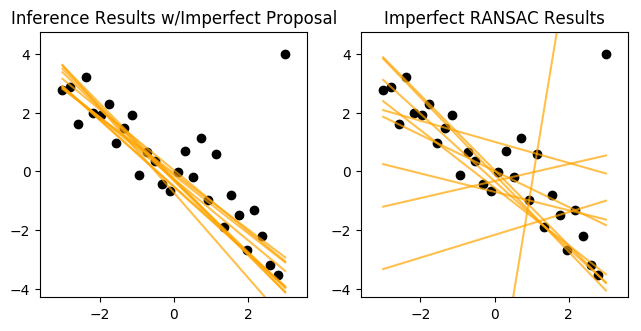

In [15]:
num_samples = 10.

#----- INFERENCE WITH DIFF NOISE--
proposal_noise = 1.
traces_reg = run_inference(xs, ys, proposal_noise, num_samples)

#----- RANSAC BY ITSELF ----------
traces_ransac = run_ransac(xs, ys, num_samples, imperfect_ransac_core)
#----------------------------------

# PLOT THE DIFFERENCES
titles = ["Inference Results w/Imperfect Proposal", "Imperfect RANSAC Results"]
trace_list = [traces_reg, traces_ransac]
plt[:figure](figsize=(20, 20))
for i=1:2
    plot_many(xs, ys, trace_list[i], i)
    plt[:title](titles[i])
end

## Conclusion

Our inference have the ability to reject proposals, therefore if the data being proposed doesn't match the data well, it won't accept it. Although this is interesting, it's important to note that custom proposals are suppose to help inference converge faster. So if that's not happening, then perhaps we don't have the right custom proposal!

### GEN and Inference

Gen is a simple language used to solve many kinds of problems, especially ones more complex than this. With the ability to do internal calculations of likelihoods and so much more, Gen gives many people the opportunity to solve a variety of problems without having to know the detailed math behind it.  